In [1]:
import zipfile
import os

ZIP_PATH = '/content/drive/MyDrive/Ara Proje/datalar/Uclm_for_DA.zip'
EXTRACT_PATH = '/content/'

print(f"📦 {ZIP_PATH} çıkarılıyor...")

with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
    zip_ref.extractall(EXTRACT_PATH)

print("✅ Çıkarma işlemi tamamlandı. Klasörler kontrol ediliyor...")

# Klasörlerin varlığını teyit edelim
otuz_train = '/content/uclm_full_analysis/otuz/train'
otuz_test = '/content/uclm_full_analysis/otuz/test'

if os.path.exists(otuz_train):
    print(f"🚀 Başarılı! OTUZ grubu hazır.\nTrain yolu: {otuz_train}\nTest yolu: {otuz_test}")
else:
    print("⚠️ Bir sorun var, klasör yolu beklenen yerde değil!")

📦 /content/drive/MyDrive/Ara Proje/datalar/Uclm_for_DA.zip çıkarılıyor...
✅ Çıkarma işlemi tamamlandı. Klasörler kontrol ediliyor...
⚠️ Bir sorun var, klasör yolu beklenen yerde değil!


In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# --- 1. YOLLAR (Ekran görüntüsündeki yapıya göre güncellendi) ---
# Görüntüde klasör uclm_full_analysis içinde değil, doğrudan content altında görünüyor.
BASE_PATH = '/content/otuz'
TRAIN_DIR = os.path.join(BASE_PATH, 'train')
TEST_DIR = os.path.join(BASE_PATH, 'test')

# Modelin Drive'daki yolu
MODEL_PATH = '/content/drive/MyDrive/Ara Proje/saved_models/ResNet_Results/Resnet_model_with_BUSI.keras'

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
DA_LR = 0.0005

# --- 2. VERİ YÜKLEYİCİLER (Zekice Bölümleme) ---

# A) Train Jeneratörü
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, class_mode='categorical'
)

# B) Test Klasörünü %20 Val (Kontrol) - %80 Pure Test (Sınav) Bölüyoruz
test_val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

# Validation: Test klasörünün %20'si
val_gen = test_val_datagen.flow_from_directory(
    TEST_DIR, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', subset='validation', shuffle=False
)

# Pure Test: Test klasörünün %80'i (Daha sonra predict için kullanacağız)
pure_test_gen = test_val_datagen.flow_from_directory(
    TEST_DIR, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', subset='training', shuffle=False
)

# --- 3. MODELİ YÜKLE VE HAZIRLA ---
print(f"🔄 BUSI Ön Eğitimli ResNet50 yükleniyor...")
if not os.path.exists(MODEL_PATH):
    print("❌ HATA: Model bulunamadı! Lütfen Drive yolunu kontrol et.")
else:
    model = load_model(MODEL_PATH)
    model.trainable = True # Domain Adaptation için tüm katmanları açtık

    model.compile(optimizer=Adam(learning_rate=DA_LR),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # --- 4. CALLBACKS ---
    checkpoint = ModelCheckpoint('/content/best_resnet_DA_30.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
    # Patience değerini biraz artırdım (8), ResNet bazen geç açılır
    early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

    # --- 5. EĞİTİM (DOMAIN ADAPTATION) ---
    print("\n🚀 ResNet DA_30 Eğitimi Başlıyor...")
    model.fit(
        train_gen,
        epochs=50,
        validation_data=val_gen,
        callbacks=[checkpoint, early_stop]
    )

    # --- 6. DRIVE'A KAYDET ---
    save_dir = "/content/drive/MyDrive/Ara Proje/saved_models/ResNet_Results/DA_Results/"
    if not os.path.exists(save_dir): os.makedirs(save_dir)
    model.save(os.path.join(save_dir, "resnet_DA_30_final.keras"))
    print(f"✅ DA_30 Modeli başarıyla kaydedildi.")

Found 648 images belonging to 3 classes.
Found 302 images belonging to 3 classes.
Found 1214 images belonging to 3 classes.
🔄 BUSI Ön Eğitimli ResNet50 yükleniyor...


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 40 variables whereas the saved optimizer has 78 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



🚀 ResNet DA_30 Eğitimi Başlıyor...
Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 863ms/step - accuracy: 0.5469 - loss: 1.6633
Epoch 1: val_accuracy improved from -inf to 0.35099, saving model to /content/best_resnet_DA_30.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.5499 - loss: 1.6408 - val_accuracy: 0.3510 - val_loss: 48.5259
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - accuracy: 0.8411 - loss: 0.4462
Epoch 2: val_accuracy improved from 0.35099 to 0.40397, saving model to /content/best_resnet_DA_30.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 18s 855ms/step - accuracy: 0.8411 - loss: 0.4468 - val_accuracy: 0.4040 - val_loss: 16.0447
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - accuracy: 0.9401 - loss: 0.2576
Epoch 3: val_accuracy improved from 0.40397 to 0.59603, saving model to /content/best_resnet_DA_30.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 18s 865ms/step - accuracy: 0.9407 - loss: 0.2559 - val_accuracy: 0.5960 - val_loss: 2.1163
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [ ]:
import numpy as np
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix

# 1. En İyi Modeli Yükle (Checkpoint ile kaydedilen en iyi ağırlıklar)
MODEL_PATH = '/content/best_resnet_DA_30.keras'
print(f"🔄 ResNet DA_30 Şampiyon Modeli Yükleniyor...")
final_model = load_model(MODEL_PATH)

# 2. Pure Test Jeneratörünü Tekrar Hatırlatalım
# (Eğer hafızadan silindiyse diye yolu tekrar tanımlıyoruz)
TEST_DIR = '/content/otuz/test'
test_val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)

pure_test_gen = test_val_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training', # %80'lik kısım
    shuffle=False
)

# 3. TAHMİN VE ANALİZ
print("\n🔍 1214 resim üzerinde final testi başlıyor...")
Y_pred = final_model.predict(pure_test_gen)
y_pred = np.argmax(Y_pred, axis=1)
y_true = pure_test_gen.classes
class_labels = list(pure_test_gen.class_indices.keys())

# 4. KARNE (Classification Report)
print("\n🔥 RESNET DA_30 PURE TEST SONUÇLARI:")
print("-" * 60)
report = classification_report(y_true, y_pred, target_names=class_labels, digits=4)
print(report)

# Accuracy hesapla
final_acc = np.sum(y_true == y_pred) / len(y_true)
print(f"\n✅ FINAL PURE TEST ACCURACY: %{final_acc*100:.2f}")

🔄 ResNet DA_30 Şampiyon Modeli Yükleniyor...
Found 1214 images belonging to 3 classes.

🔍 1214 resim üzerinde final testi başlıyor...
38/38 ━━━━━━━━━━━━━━━━━━━━ 30s 695ms/step

🔥 RESNET DA_30 PURE TEST SONUÇLARI:
------------------------------------------------------------
              precision    recall  f1-score   support

      benign     0.8391    0.8208    0.8299       413
      malign     0.8089    0.7992    0.8040       249
      normal     0.8865    0.9058    0.8961       552

    accuracy                         0.8550      1214
   macro avg     0.8449    0.8419    0.8433      1214
weighted avg     0.8545    0.8550    0.8547      1214


✅ FINAL PURE TEST ACCURACY: %85.50


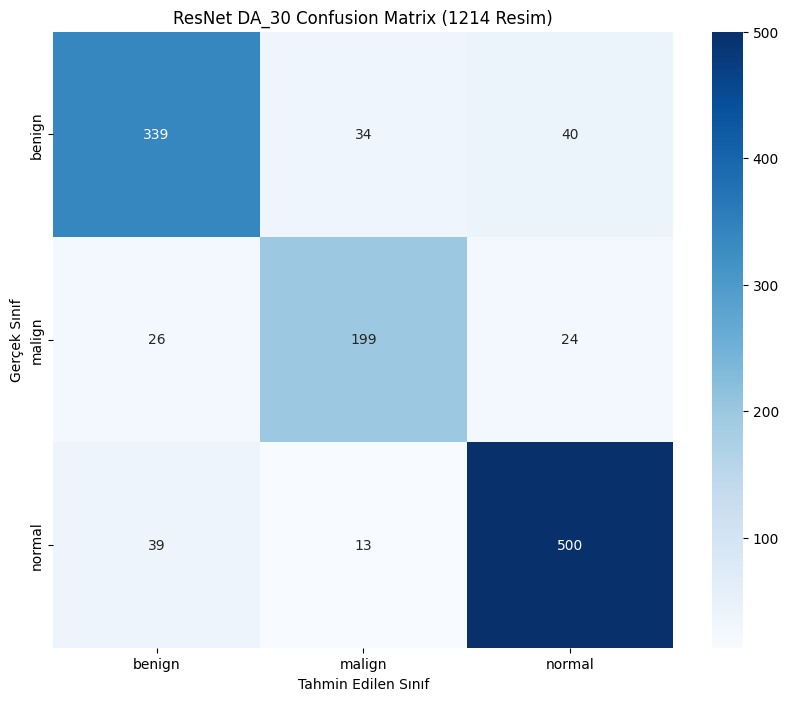


🔍 HATA ANALİZİ:
benign     sınıfında 413 resmin 339 tanesi doğru bilindi. (Başarı: %82.08)
malign     sınıfında 249 resmin 199 tanesi doğru bilindi. (Başarı: %79.92)
normal     sınıfında 552 resmin 500 tanesi doğru bilindi. (Başarı: %90.58)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. Matrisi Hesapla
cm = confusion_matrix(y_true, y_pred)

# 2. Görselleştir
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)

plt.title('ResNet DA_30 Confusion Matrix (1214 Resim)')
plt.ylabel('Gerçek Sınıf')
plt.xlabel('Tahmin Edilen Sınıf')
plt.show()

# 3. Hata Analizi Yazdır
print("\n🔍 HATA ANALİZİ:")
for i, label in enumerate(class_labels):
    correct = cm[i, i]
    total = np.sum(cm[i, :])
    print(f"{label:<10} sınıfında {total} resmin {correct} tanesi doğru bilindi. (Başarı: %{100*correct/total:.2f})")

In [ ]:
import os
import zipfile
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.resnet50 import preprocess_input

# 1. denem.zip dosyasını dışarı çıkar (Eğer daha önce çıkarılmadıysa)
ZIP_PATH = '/content/denem.zip'
EXTRACT_PATH = '/content/denem_resnet_30'

if not os.path.exists(EXTRACT_PATH):
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(EXTRACT_PATH)
    print("✅ denem.zip başarıyla çıkarıldı.")

# 2. ResNet DA_30 Şampiyon Modeli Yükle
# Not: Eğitimde kaydettiğin en iyi ağırlıkları kullanıyoruz
model_path = '/content/best_resnet_DA_30.keras'
if os.path.exists(model_path):
    model = load_model(model_path)
    print("🔄 ResNet DA_30 Modeli yüklendi. Tahminler başlıyor...\n")
else:
    print("❌ HATA: Model dosyası bulunamadı!")

# 3. Tahmin Fonksiyonu
def predict_external_images(folder_path):
    class_labels = ['benign', 'malign', 'normal']
    correct_count = 0
    total_count = 0

    print(f"{'Resim Adı':<45} --> {'Tahmin':<15}")
    print("-" * 70)

    # Klasör içindeki resimleri tara
    for img_name in sorted(os.listdir(folder_path)):
        if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(folder_path, img_name)

            # Resmi yükle ve ResNet formatına hazırla (224x224)
            img = image.load_img(img_path, target_size=(224, 224))
            img_array = image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array = preprocess_input(img_array)

            # Tahmin yap
            preds = model.predict(img_array, verbose=0)
            score = np.max(preds)
            predicted_class = class_labels[np.argmax(preds)]

            print(f"{img_name:<45} --> {predicted_class} (%{score*100:.2f})")
            total_count += 1

    return total_count

# Testi Başlat
# denem.zip içinden genellikle aynı isimde bir klasör çıkar, onu kontrol edelim
folder_to_test = os.path.join(EXTRACT_PATH, 'denem')
if not os.path.exists(folder_to_test):
    folder_to_test = EXTRACT_PATH

predict_external_images(folder_to_test)

✅ denem.zip başarıyla çıkarıldı.
🔄 ResNet DA_30 Modeli yüklendi. Tahminler başlıyor...

Resim Adı                                     --> Tahmin         
----------------------------------------------------------------------
benign (100)-rotated1-rotated2.png            --> benign (%99.97)
benign (101)-rotated1.jpg                     --> benign (%100.00)
benign (101)-sharpened.jpg                    --> benign (%100.00)
benign (102)-rotated2-rotated1.png            --> benign (%100.00)
benign (103)-rotated2-rotated1.png            --> benign (%100.00)
benign (105)-rotated2-rotated2.png            --> benign (%100.00)
benign (105)-rotated2.png                     --> benign (%100.00)
benign (107)-rotated2-sharpened.png           --> benign (%100.00)
benign (108)-rotated2-rotated2.png            --> normal (%74.90)
benign (110)-sharpened-sharpened.png          --> benign (%72.20)
benign (111)-rotated1-sharpened.png           --> benign (%100.00)
malignant (105)-rotated32.png            

27

naset %30 start

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.nasnet import preprocess_input # NASNet'e özel güncellendi
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# --- 1. YOLLAR ---
BASE_PATH = '/content/otuz'
TRAIN_DIR = os.path.join(BASE_PATH, 'train')
TEST_DIR = os.path.join(BASE_PATH, 'test')

# Drive'daki BUSI ön eğitimli NASNet modelinin yolu
MODEL_PATH =  '/content/drive/MyDrive/Ara Proje/saved_models/Nasnet_Results/nasnet_model_with_BUSI.keras'

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
DA_LR = 0.0005 # Senin bulduğun o sihirli hız!

# --- 2. VERİ YÜKLEYİCİLER ---
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, class_mode='categorical'
)

test_val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

val_gen = test_val_datagen.flow_from_directory(
    TEST_DIR, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', subset='validation', shuffle=False
)

pure_test_gen = test_val_datagen.flow_from_directory(
    TEST_DIR, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', subset='training', shuffle=False
)

# --- 3. MODELİ YÜKLE VE HAZIRLA ---
print(f"🔄 BUSI Ön Eğitimli NASNetLarge yükleniyor...")
if not os.path.exists(MODEL_PATH):
    print("❌ HATA: Model bulunamadı! Lütfen yolu kontrol et.")
else:
    model = load_model(MODEL_PATH)
    model.trainable = True

    model.compile(optimizer=Adam(learning_rate=DA_LR),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # --- 4. CALLBACKS ---
    checkpoint = ModelCheckpoint('/content/best_nasnet_DA_30.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
    early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

    # --- 5. EĞİTİM ---
    print("\n🚀 NASNet DA_30 Eğitimi Başlıyor (LR: 0.0005)...")
    model.fit(
        train_gen,
        epochs=50,
        validation_data=val_gen,
        callbacks=[checkpoint, early_stop]
    )

    # --- 6. DRIVE'A KAYDET ---
    save_dir = "/content/drive/MyDrive/Ara Proje/saved_models/NasNet_Results/DA_Results/"
    if not os.path.exists(save_dir): os.makedirs(save_dir)
    model.save(os.path.join(save_dir, "nasnet_DA_30_final.keras"))
    print(f"✅ NASNet DA_30 Modeli başarıyla kaydedildi.")

Found 648 images belonging to 3 classes.
Found 302 images belonging to 3 classes.
Found 1214 images belonging to 3 classes.
🔄 BUSI Ön Eğitimli NASNetLarge yükleniyor...

🚀 NASNet DA_30 Eğitimi Başlıyor (LR: 0.0005)...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4121 - loss: 3.2077
Epoch 1: val_accuracy improved from -inf to 0.44040, saving model to /content/best_nasnet_DA_30.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 207s 7s/step - accuracy: 0.4142 - loss: 3.1878 - val_accuracy: 0.4404 - val_loss: 1.9159
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - accuracy: 0.4789 - loss: 2.1329
Epoch 2: val_accuracy improved from 0.44040 to 0.48344, saving model to /content/best_nasnet_DA_30.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 972ms/step - accuracy: 0.4810 - loss: 2.1290 - val_accuracy: 0.4834 - val_loss: 1.5472
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 517ms/step - accuracy: 0.5580 - loss: 1.5178
Epoch 3: val_accuracy improved from 0.48344 to 0.50000, saving model to /content/best_nasnet_DA_30.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 980ms/step - accuracy: 0.5574 - loss: 1.5265 - val_accuracy: 0.5000 - val_loss: 1.4740
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - accuracy: 0.5241 - loss: 1.

In [ ]:
import numpy as np
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.nasnet import preprocess_input # NASNet'e özel!
from sklearn.metrics import classification_report, confusion_matrix

# 1. En İyi NASNet Modelini Yükle
MODEL_PATH = '/content/best_nasnet_DA_30.keras'
print(f"🔄 NASNet DA_30 Şampiyon Modeli Yükleniyor...")
final_model = load_model(MODEL_PATH)

# 2. Pure Test Jeneratörü
TEST_DIR = '/content/otuz/test'
test_val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)

pure_test_gen = test_val_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training', # %80'lik pure test kısmı
    shuffle=False
)

# 3. TAHMİN VE ANALİZ
print("\n🔍 NASNet ile 1214 resim üzerinde final testi başlıyor...")
Y_pred = final_model.predict(pure_test_gen)
y_pred = np.argmax(Y_pred, axis=1)
y_true = pure_test_gen.classes
class_labels = list(pure_test_gen.class_indices.keys())

# 4. KARNE
print("\n🔥 NASNET DA_30 PURE TEST SONUÇLARI:")
print("-" * 60)
report = classification_report(y_true, y_pred, target_names=class_labels, digits=4)
print(report)

final_acc = np.sum(y_true == y_pred) / len(y_true)
print(f"\n✅ NASNET FINAL PURE TEST ACCURACY: %{final_acc*100:.2f}")

🔄 NASNet DA_30 Şampiyon Modeli Yükleniyor...
Found 1214 images belonging to 3 classes.

🔍 NASNet ile 1214 resim üzerinde final testi başlıyor...
38/38 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step

🔥 NASNET DA_30 PURE TEST SONUÇLARI:
------------------------------------------------------------
              precision    recall  f1-score   support

      benign     0.7005    0.6174    0.6564       413
      malign     0.5348    0.4940    0.5136       249
      normal     0.7145    0.8025    0.7560       552

    accuracy                         0.6763      1214
   macro avg     0.6499    0.6380    0.6420      1214
weighted avg     0.6729    0.6763    0.6724      1214


✅ NASNET FINAL PURE TEST ACCURACY: %67.63


Found 1214 images belonging to 3 classes.

🔍 NASNet Matris Analizi Başlıyor...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


38/38 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step


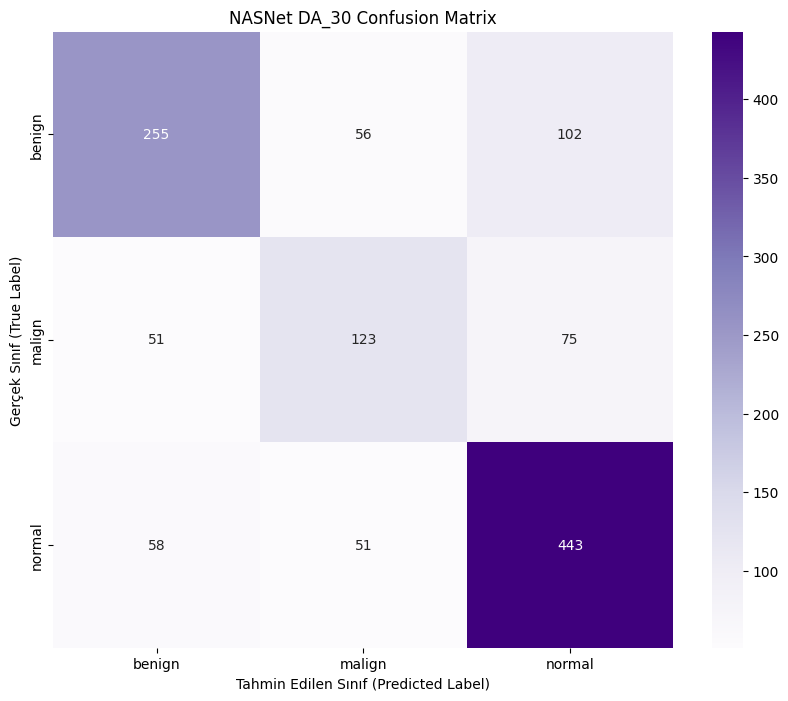


🔥 NASNET DA_30 DETAYLI SINIF RAPORU:
------------------------------------------------------------
              precision    recall  f1-score   support

      benign     0.7005    0.6174    0.6564       413
      malign     0.5348    0.4940    0.5136       249
      normal     0.7145    0.8025    0.7560       552

    accuracy                         0.6763      1214
   macro avg     0.6499    0.6380    0.6420      1214
weighted avg     0.6729    0.6763    0.6724      1214



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.nasnet import preprocess_input
from sklearn.metrics import confusion_matrix, classification_report

# 1. Modeli Yükle
MODEL_PATH = '/content/best_nasnet_DA_30.keras'
model = load_model(MODEL_PATH)

# 2. Test Verisini Hazırla (Pure Test - %80)
TEST_DIR = '/content/otuz/test'
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)
pure_test_gen = test_datagen.flow_from_directory(
    TEST_DIR, target_size=(224, 224), batch_size=32,
    class_mode='categorical', subset='training', shuffle=False
)

# 3. Tahminleri Al
print("\n🔍 NASNet Matris Analizi Başlıyor...")
Y_pred = model.predict(pure_test_gen)
y_pred = np.argmax(Y_pred, axis=1)
y_true = pure_test_gen.classes
class_labels = list(pure_test_gen.class_indices.keys())

# 4. CONFUSION MATRIX ÇİZDİR
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=class_labels, yticklabels=class_labels)

plt.title('NASNet DA_30 Confusion Matrix')
plt.ylabel('Gerçek Sınıf (True Label)')
plt.xlabel('Tahmin Edilen Sınıf (Predicted Label)')
plt.show()

# 5. SINIF BAZLI RAPOR
print("\n🔥 NASNET DA_30 DETAYLI SINIF RAPORU:")
print("-" * 60)
print(classification_report(y_true, y_pred, target_names=class_labels, digits=4))

In [ ]:
import os
import zipfile
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.nasnet import preprocess_input

# 1. denem.zip Çıkarma (Klasör yoksa)
ZIP_PATH = '/content/denem.zip'
EXTRACT_PATH = '/content/denem_nasnet_30'

if not os.path.exists(EXTRACT_PATH):
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(EXTRACT_PATH)
    print("✅ denem.zip başarıyla çıkarıldı.")

# 2. Model Yükle
model_path = '/content/best_nasnet_DA_30.keras'
model = load_model(model_path)
print("🔄 NASNet DA_30 Modeli yüklendi. Tahminler başlıyor...\n")

# 3. Tahmin Fonksiyonu
def predict_nasnet_external(folder_path):
    class_labels = ['benign', 'malign', 'normal']
    print(f"{'Resim Adı':<45} --> {'Tahmin':<15}")
    print("-" * 70)

    for img_name in sorted(os.listdir(folder_path)):
        if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(folder_path, img_name)
            img = image.load_img(img_path, target_size=(224, 224))
            img_array = image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array = preprocess_input(img_array) # NASNet preprocess!

            preds = model.predict(img_array, verbose=0)
            score = np.max(preds)
            predicted_class = class_labels[np.argmax(preds)]

            print(f"{img_name:<45} --> {predicted_class} (%{score*100:.2f})")

# Testi çalıştır
folder_to_test = os.path.join(EXTRACT_PATH, 'denem')
if not os.path.exists(folder_to_test): folder_to_test = EXTRACT_PATH
predict_nasnet_external(folder_to_test)

✅ denem.zip başarıyla çıkarıldı.
🔄 NASNet DA_30 Modeli yüklendi. Tahminler başlıyor...

Resim Adı                                     --> Tahmin         
----------------------------------------------------------------------
benign (100)-rotated1-rotated2.png            --> normal (%94.28)
benign (101)-rotated1.jpg                     --> benign (%100.00)
benign (101)-sharpened.jpg                    --> benign (%100.00)
benign (102)-rotated2-rotated1.png            --> benign (%99.92)
benign (103)-rotated2-rotated1.png            --> benign (%100.00)
benign (105)-rotated2-rotated2.png            --> benign (%91.33)
benign (105)-rotated2.png                     --> benign (%99.39)
benign (107)-rotated2-sharpened.png           --> benign (%99.94)
benign (108)-rotated2-rotated2.png            --> normal (%95.75)
benign (110)-sharpened-sharpened.png          --> benign (%99.98)
benign (111)-rotated1-sharpened.png           --> benign (%100.00)
malignant (105)-rotated32.png                

XCEPTION


In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import preprocess_input # Xception'a özel!
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# --- 1. YOLLAR ---
BASE_PATH = '/content/otuz'
TRAIN_DIR = os.path.join(BASE_PATH, 'train')
TEST_DIR = os.path.join(BASE_PATH, 'test')

# Xception ön eğitimli (BUSI) modelinin yolu
# Not: Klasör ismindeki büyük/küçük harfe dikkat et, genelde Xception olarak açılır.
MODEL_PATH = '/content/drive/MyDrive/Ara Proje/saved_models/Xception_Results/xception_model_with_BUSI.keras'

IMAGE_SIZE =(224,224) # Xception en iyi bu boyutta çalışır
BATCH_SIZE = 32
DA_LR = 0.001 # Kazanan öğrenme hızı

# --- 2. VERİ YÜKLEYİCİLER ---
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, class_mode='categorical'
)

test_val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)

val_gen = test_val_datagen.flow_from_directory(
    TEST_DIR, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', subset='validation', shuffle=False
)

pure_test_gen = test_val_datagen.flow_from_directory(
    TEST_DIR, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', subset='training', shuffle=False
)

# --- 3. MODELİ YÜKLE VE HAZIRLA ---
print(f"🔄 BUSI Ön Eğitimli Xception yükleniyor...")
if not os.path.exists(MODEL_PATH):
    print(f"❌ HATA: Model bulunamadı! Lütfen yolu kontrol et: {MODEL_PATH}")
else:
    model = load_model(MODEL_PATH)
    model.trainable = True

    model.compile(optimizer=Adam(learning_rate=DA_LR),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # --- 4. CALLBACKS ---
    checkpoint = ModelCheckpoint('/content/best_xception_DA_30.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
    early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

    # --- 5. EĞİTİM ---
    print("\n🚀 Xception DA_30 Eğitimi Başlıyor (LR: 0.0005)...")
    model.fit(
        train_gen,
        epochs=50,
        validation_data=val_gen,
        callbacks=[checkpoint, early_stop]
    )

    # --- 6. DRIVE'A KAYDET ---
    save_dir = "/content/drive/MyDrive/Ara Proje/saved_models/Xception_Results/DA_Results/"
    if not os.path.exists(save_dir): os.makedirs(save_dir)
    model.save(os.path.join(save_dir, "xception_DA_30_final.keras"))
    print(f"✅ Xception DA_30 Modeli başarıyla kaydedildi.")

Found 648 images belonging to 3 classes.
Found 302 images belonging to 3 classes.
Found 1214 images belonging to 3 classes.
🔄 BUSI Ön Eğitimli Xception yükleniyor...

🚀 Xception DA_30 Eğitimi Başlıyor (LR: 0.0005)...
Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 674ms/step - accuracy: 0.4122 - loss: 1.8402
Epoch 1: val_accuracy improved from -inf to 0.57285, saving model to /content/best_xception_DA_30.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.4136 - loss: 1.8292 - val_accuracy: 0.5728 - val_loss: 1.0825
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - accuracy: 0.4765 - loss: 1.4509
Epoch 2: val_accuracy improved from 0.57285 to 0.60596, saving model to /content/best_xception_DA_30.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 17s 810ms/step - accuracy: 0.4781 - loss: 1.4472 - val_accuracy: 0.6060 - val_loss: 0.9755
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - accuracy: 0.5368 - loss: 1.2338
Epoch 3: val_accuracy improved from 0.60596 to 0.62583, saving model to /content/

In [ ]:
# Modeli kaldığı yerden yükle
model = load_model('/content/best_xception_DA_30.keras')

# 50 epoch daha ver
model.fit(
    train_gen,
    epochs=50,
    validation_data=val_gen,
    callbacks=[checkpoint, early_stop]
)

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 682ms/step - accuracy: 0.7898 - loss: 0.5077
Epoch 1: val_accuracy did not improve from 0.71854
21/21 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.7893 - loss: 0.5086 - val_accuracy: 0.7053 - val_loss: 0.7147
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 513ms/step - accuracy: 0.7661 - loss: 0.5117
Epoch 2: val_accuracy did not improve from 0.71854
21/21 ━━━━━━━━━━━━━━━━━━━━ 16s 773ms/step - accuracy: 0.7662 - loss: 0.5122 - val_accuracy: 0.7020 - val_loss: 0.7275
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 516ms/step - accuracy: 0.7442 - loss: 0.5638
Epoch 3: val_accuracy did not improve from 0.71854
21/21 ━━━━━━━━━━━━━━━━━━━━ 16s 773ms/step - accuracy: 0.7455 - loss: 0.5627 - val_accuracy: 0.6821 - val_loss: 0.7312
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 516ms/step - accuracy: 0.7351 - loss: 0.5456
Epoch 4: val_accuracy did not improve from 0.71854
21/21 ━━━━━━━━━━━━━━━━━━━━ 16s 774ms/step - accuracy: 0.7362 - loss: 0.5452 - val_accuracy: 0.7086 - 

KeyboardInterrupt: 

🔄 Xception DA_30 Şampiyon Modeli Yükleniyor...
Found 1214 images belonging to 3 classes.

🔍 Xception ile 1214 resim üzerinde final sınavı başlıyor...
38/38 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step

🔥 XCEPTION DA_30 PURE TEST SONUÇLARI:
------------------------------------------------------------
              precision    recall  f1-score   support

      benign     0.6822    0.6392    0.6600       413
      malign     0.5424    0.5141    0.5278       249
      normal     0.7124    0.7627    0.7367       552

    accuracy                         0.6697      1214
   macro avg     0.6456    0.6387    0.6415      1214
weighted avg     0.6672    0.6697    0.6677      1214



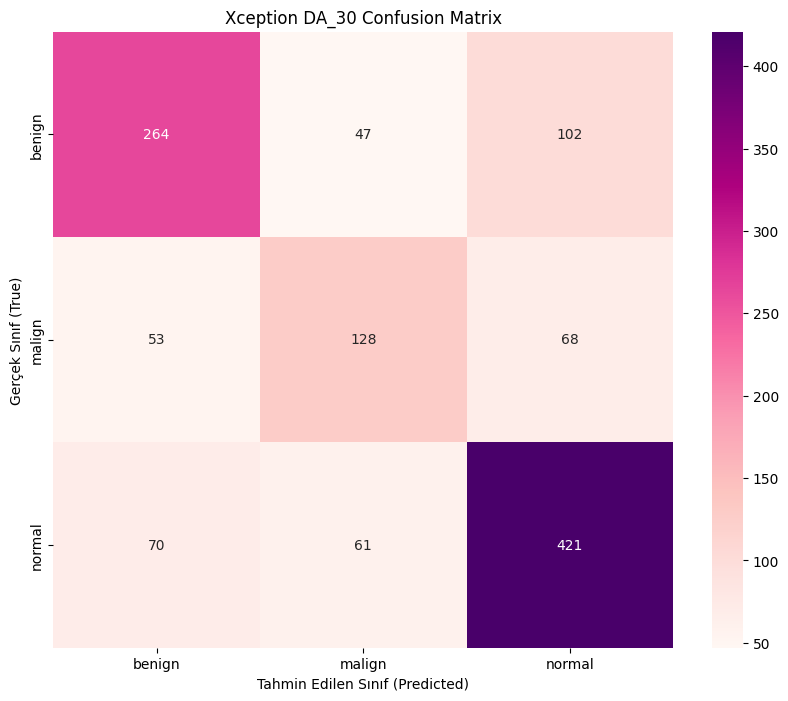


✅ XCEPTION FINAL ACCURACY: %66.97


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix

# 1. En İyi Kaydedilen Xception Modelini Yükle
MODEL_PATH = '/content/best_xception_DA_30.keras'
print(f"🔄 Xception DA_30 Şampiyon Modeli Yükleniyor...")
model = load_model(MODEL_PATH)

# 2. Pure Test Jeneratörü (%80'lik dilim)
TEST_DIR = '/content/otuz/test'
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)

pure_test_gen = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training', # %80 pure test
    shuffle=False
)

# 3. TAHMİN VE ANALİZ
print("\n🔍 Xception ile 1214 resim üzerinde final sınavı başlıyor...")
Y_pred = model.predict(pure_test_gen)
y_pred = np.argmax(Y_pred, axis=1)
y_true = pure_test_gen.classes
class_labels = list(pure_test_gen.class_indices.keys())

# 4. 4 METRİK VE SINIFLANDIRMA RAPORU
print("\n🔥 XCEPTION DA_30 PURE TEST SONUÇLARI:")
print("-" * 60)
report = classification_report(y_true, y_pred, target_names=class_labels, digits=4)
print(report)

# 5. CONFUSION MATRIX GÖRSELLEŞTİRME
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='RdPu',
            xticklabels=class_labels, yticklabels=class_labels)

plt.title('Xception DA_30 Confusion Matrix')
plt.ylabel('Gerçek Sınıf (True)')
plt.xlabel('Tahmin Edilen Sınıf (Predicted)')
plt.show()

# 6. Özet Accuracy
final_acc = np.sum(y_true == y_pred) / len(y_true)
print(f"\n✅ XCEPTION FINAL ACCURACY: %{final_acc*100:.2f}")

In [ ]:
import os
import zipfile
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.xception import preprocess_input

# 1. denem.zip Çıkarma (Klasör yoksa)
ZIP_PATH = '/content/denem.zip'
EXTRACT_PATH = '/content/denem_xception_30'

if not os.path.exists(EXTRACT_PATH):
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(EXTRACT_PATH)
    print("✅ denem.zip başarıyla çıkarıldı.")

# 2. En İyi Xception Modelini Yükle
model_path = '/content/best_xception_DA_30.keras'
if os.path.exists(model_path):
    model = load_model(model_path)
    print("🔄 Xception DA_30 Modeli yüklendi. Tahminler başlıyor...\n")
else:
    print("❌ HATA: Model dosyası bulunamadı!")

# 3. Tahmin Fonksiyonu
def predict_xception_external(folder_path):
    class_labels = ['benign', 'malign', 'normal']
    print(f"{'Resim Adı':<45} --> {'Tahmin':<15}")
    print("-" * 70)

    for img_name in sorted(os.listdir(folder_path)):
        if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(folder_path, img_name)

            # Xception için hazırlık (224x224 seçtiğin için öyle devam ediyoruz)
            img = image.load_img(img_path, target_size=(224, 224))
            img_array = image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array = preprocess_input(img_array)

            # Tahmin
            preds = model.predict(img_array, verbose=0)
            score = np.max(preds)
            predicted_class = class_labels[np.argmax(preds)]

            print(f"{img_name:<45} --> {predicted_class} (%{score*100:.2f})")

# Testi Başlat
folder_to_test = os.path.join(EXTRACT_PATH, 'denem')
if not os.path.exists(folder_to_test):
    folder_to_test = EXTRACT_PATH

predict_xception_external(folder_to_test)

✅ denem.zip başarıyla çıkarıldı.
🔄 Xception DA_30 Modeli yüklendi. Tahminler başlıyor...

Resim Adı                                     --> Tahmin         
----------------------------------------------------------------------
benign (100)-rotated1-rotated2.png            --> normal (%65.38)
benign (101)-rotated1.jpg                     --> benign (%100.00)
benign (101)-sharpened.jpg                    --> benign (%100.00)
benign (102)-rotated2-rotated1.png            --> benign (%50.54)
benign (103)-rotated2-rotated1.png            --> benign (%100.00)
benign (105)-rotated2-rotated2.png            --> benign (%100.00)
benign (105)-rotated2.png                     --> benign (%100.00)
benign (107)-rotated2-sharpened.png           --> benign (%99.92)
benign (108)-rotated2-rotated2.png            --> benign (%75.46)
benign (110)-sharpened-sharpened.png          --> normal (%84.50)
benign (111)-rotated1-sharpened.png           --> benign (%100.00)
malignant (105)-rotated32.png            

DENSENET DENEME

In [5]:
import os
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# ResNet yerine DenseNet preprocessing fonksiyonunu içe aktarıyoruz
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# --- 1. YOLLAR ---
BASE_PATH = '/content/otuz'
TRAIN_DIR = os.path.join(BASE_PATH, 'train')
TEST_DIR = os.path.join(BASE_PATH, 'test')

# Modelin Drive'daki yeni yolu (DenseNet olarak güncellendi)
MODEL_PATH = '/content/drive/MyDrive/Ara Proje/saved_models/DenseNet_Results/DenseNet121_best_lr_1en03.keras'

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
DA_LR = 0.0005

# --- 2. VERİ YÜKLEYİCİLER ---
# DenseNet için özelleşmiş preprocess_input kullanılıyor
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, class_mode='categorical'
)

test_val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

val_gen = test_val_datagen.flow_from_directory(
    TEST_DIR, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', subset='validation', shuffle=False
)

pure_test_gen = test_val_datagen.flow_from_directory(
    TEST_DIR, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', subset='training', shuffle=False
)

# --- 3. MODELİ YÜKLE VE HAZIRLA ---
print(f"🔄 BUSI Ön Eğitimli DenseNet yükleniyor...")
if not os.path.exists(MODEL_PATH):
    print(f"❌ HATA: Model bulunamadı! Yol: {MODEL_PATH}")
else:
    model = load_model(MODEL_PATH)
    model.trainable = True # Domain Adaptation için tüm katmanları açtık

    model.compile(optimizer=Adam(learning_rate=DA_LR),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # --- 4. CALLBACKS ---
    # Dosya adını densenet olarak güncelledik
    checkpoint = ModelCheckpoint('/content/best_densenet_DA_30.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
    early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

    # --- 5. EĞİTİM (DOMAIN ADAPTATION) ---
    print("\n🚀 DenseNet DA_30 Eğitimi Başlıyor...")
    model.fit(
        train_gen,
        epochs=50,
        validation_data=val_gen,
        callbacks=[checkpoint, early_stop]
    )

    # --- 6. DRIVE'A KAYDET ---
    save_dir = "/content/drive/MyDrive/Ara Proje/saved_models/DenseNet_Results/DA_Results/"
    if not os.path.exists(save_dir): os.makedirs(save_dir)
    model.save(os.path.join(save_dir, "densenet_DA_30_final.keras"))
    print(f"✅ DA_30 Modeli (DenseNet) başarıyla kaydedildi.")

Found 648 images belonging to 3 classes.
Found 302 images belonging to 3 classes.
Found 1214 images belonging to 3 classes.
🔄 BUSI Ön Eğitimli DenseNet yükleniyor...

🚀 DenseNet DA_30 Eğitimi Başlıyor...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4737 - loss: 1.2963
Epoch 1: val_accuracy improved from -inf to 0.57947, saving model to /content/best_densenet_DA_30.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.4744 - loss: 1.2948 - val_accuracy: 0.5795 - val_loss: 1.0379
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - accuracy: 0.5405 - loss: 1.1394
Epoch 2: val_accuracy improved from 0.57947 to 0.61258, saving model to /content/best_densenet_DA_30.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 17s 844ms/step - accuracy: 0.5390 - loss: 1.1423 - val_accuracy: 0.6126 - val_loss: 0.9435
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 520ms/step - accuracy: 0.5071 - loss: 1.1746
Epoch 3: val_accuracy improved from 0.61258 to 0.63245, saving model to /content/best_densenet_DA_30.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 17s 838ms/step - accuracy: 0.5078 - loss: 1.1742 - val_accuracy: 0.6325 - val_loss: 0.9244
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - accuracy: 0.5287 - los

🔄 DenseNet DA_30 Şampiyon Modeli Yükleniyor: /content/best_densenet_DA_30.keras
Found 1214 images belonging to 3 classes.

🔍 DenseNet ile 1214 resim üzerinde final sınavı başlıyor...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


38/38 ━━━━━━━━━━━━━━━━━━━━ 49s 988ms/step

🔥 DENSENET DA_30 PURE TEST SONUÇLARI (Precision, Recall, F1, Accuracy):
-----------------------------------------------------------------
              precision    recall  f1-score   support

      benign     0.7275    0.6465    0.6846       413
      malign     0.6804    0.5301    0.5959       249
      normal     0.7243    0.8569    0.7851       552

    accuracy                         0.7183      1214
   macro avg     0.7108    0.6778    0.6885      1214
weighted avg     0.7164    0.7183    0.7121      1214



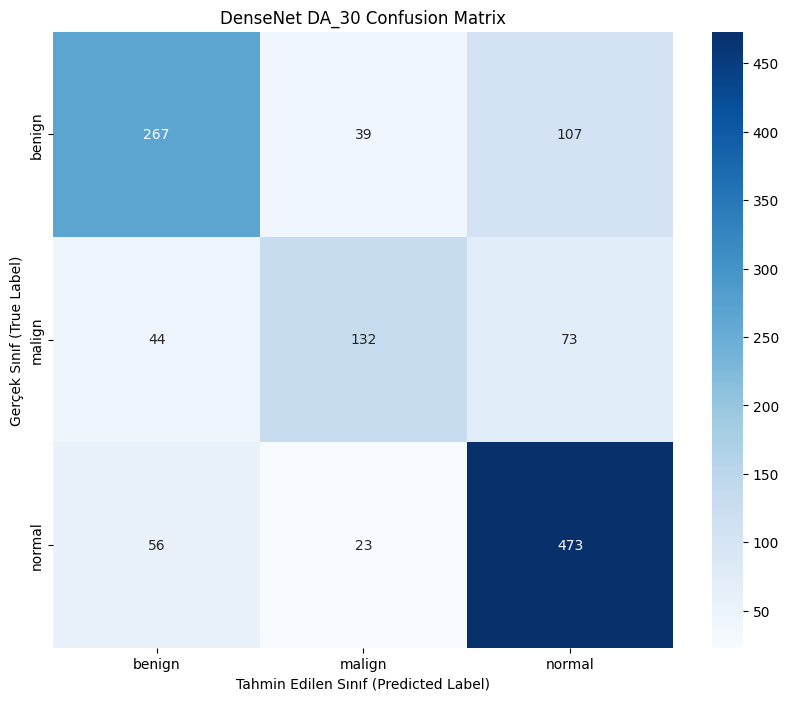


✅ DENSENET FINAL TEST ACCURACY: %71.83
-----------------------------------------------------------------


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix

# --- 1. EN İYİ KAYDEDİLEN DENSENET MODELİNİ YÜKLE ---
# Eğitim sırasında Checkpoint ile kaydedilen en iyi modeli seçiyoruz
MODEL_PATH = '/content/best_densenet_DA_30.keras'
print(f"🔄 DenseNet DA_30 Şampiyon Modeli Yükleniyor: {MODEL_PATH}")

if not os.path.exists(MODEL_PATH):
    print("❌ HATA: Model dosyası bulunamadı! Lütfen yolu kontrol edin.")
else:
    model = load_model(MODEL_PATH)

    # --- 2. PURE TEST JENERATÖRÜ (%80'lik dilim) ---
    TEST_DIR = '/content/otuz/test'
    test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)

    # Eğitim kodunla uyumlu olması için 'subset=training' (%80'lik kısım) kullanıyoruz
    pure_test_gen = test_datagen.flow_from_directory(
        TEST_DIR,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        subset='training',
        shuffle=False
    )

    # --- 3. TAHMİN VE ANALİZ ---
    print(f"\n🔍 DenseNet ile {pure_test_gen.samples} resim üzerinde final sınavı başlıyor...")
    Y_pred = model.predict(pure_test_gen)
    y_pred = np.argmax(Y_pred, axis=1)
    y_true = pure_test_gen.classes
    class_labels = list(pure_test_gen.class_indices.keys())

    # --- 4. 4 METRİK VE SINIFLANDIRMA RAPORU ---
    print("\n🔥 DENSENET DA_30 PURE TEST SONUÇLARI (Precision, Recall, F1, Accuracy):")
    print("-" * 65)
    report = classification_report(y_true, y_pred, target_names=class_labels, digits=4)
    print(report)

    # --- 5. CONFUSION MATRIX GÖRSELLEŞTİRME ---
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    # DenseNet için görsel rengini 'Blues' veya 'GnBu' yaparak ResNet'ten ayırabilirsin
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels)

    plt.title('DenseNet DA_30 Confusion Matrix')
    plt.ylabel('Gerçek Sınıf (True Label)')
    plt.xlabel('Tahmin Edilen Sınıf (Predicted Label)')
    plt.show()

    # --- 6. ÖZET ACCURACY ---
    final_acc = np.sum(y_true == y_pred) / len(y_true)
    print(f"\n✅ DENSENET FINAL TEST ACCURACY: %{final_acc*100:.2f}")
    print("-" * 65)

🚀 27 adet resim bulundu, test başlıyor...

🔄 Model yükleniyor: /content/best_densenet_DA_30.keras
[1] benign (100)-rotated1-rotated2.png -> TAHMİN: Benign (%95.25)
[2] benign (101)-rotated1.jpg -> TAHMİN: Benign (%98.77)
[3] benign (101)-sharpened.jpg -> TAHMİN: Benign (%97.59)
[4] benign (102)-rotated2-rotated1.png -> TAHMİN: Benign (%86.86)
[5] benign (103)-rotated2-rotated1.png -> TAHMİN: Benign (%99.31)
[6] benign (105)-rotated2-rotated2.png -> TAHMİN: Benign (%99.91)
[7] benign (105)-rotated2.png -> TAHMİN: Benign (%99.15)
[8] benign (107)-rotated2-sharpened.png -> TAHMİN: Benign (%93.92)
[9] benign (108)-rotated2-rotated2.png -> TAHMİN: Normal (%48.97)
[10] benign (110)-sharpened-sharpened.png -> TAHMİN: Benign (%82.39)
[11] benign (111)-rotated1-sharpened.png -> TAHMİN: Benign (%89.43)
[12] malignant (105)-rotated32.png -> TAHMİN: Benign (%49.90)
[13] malignant (106)-sharpened-rotated32.png -> TAHMİN: Malignant (%60.59)
[14] malignant (107)-rotated1-rotated32.png -> TAHMİN: Norm

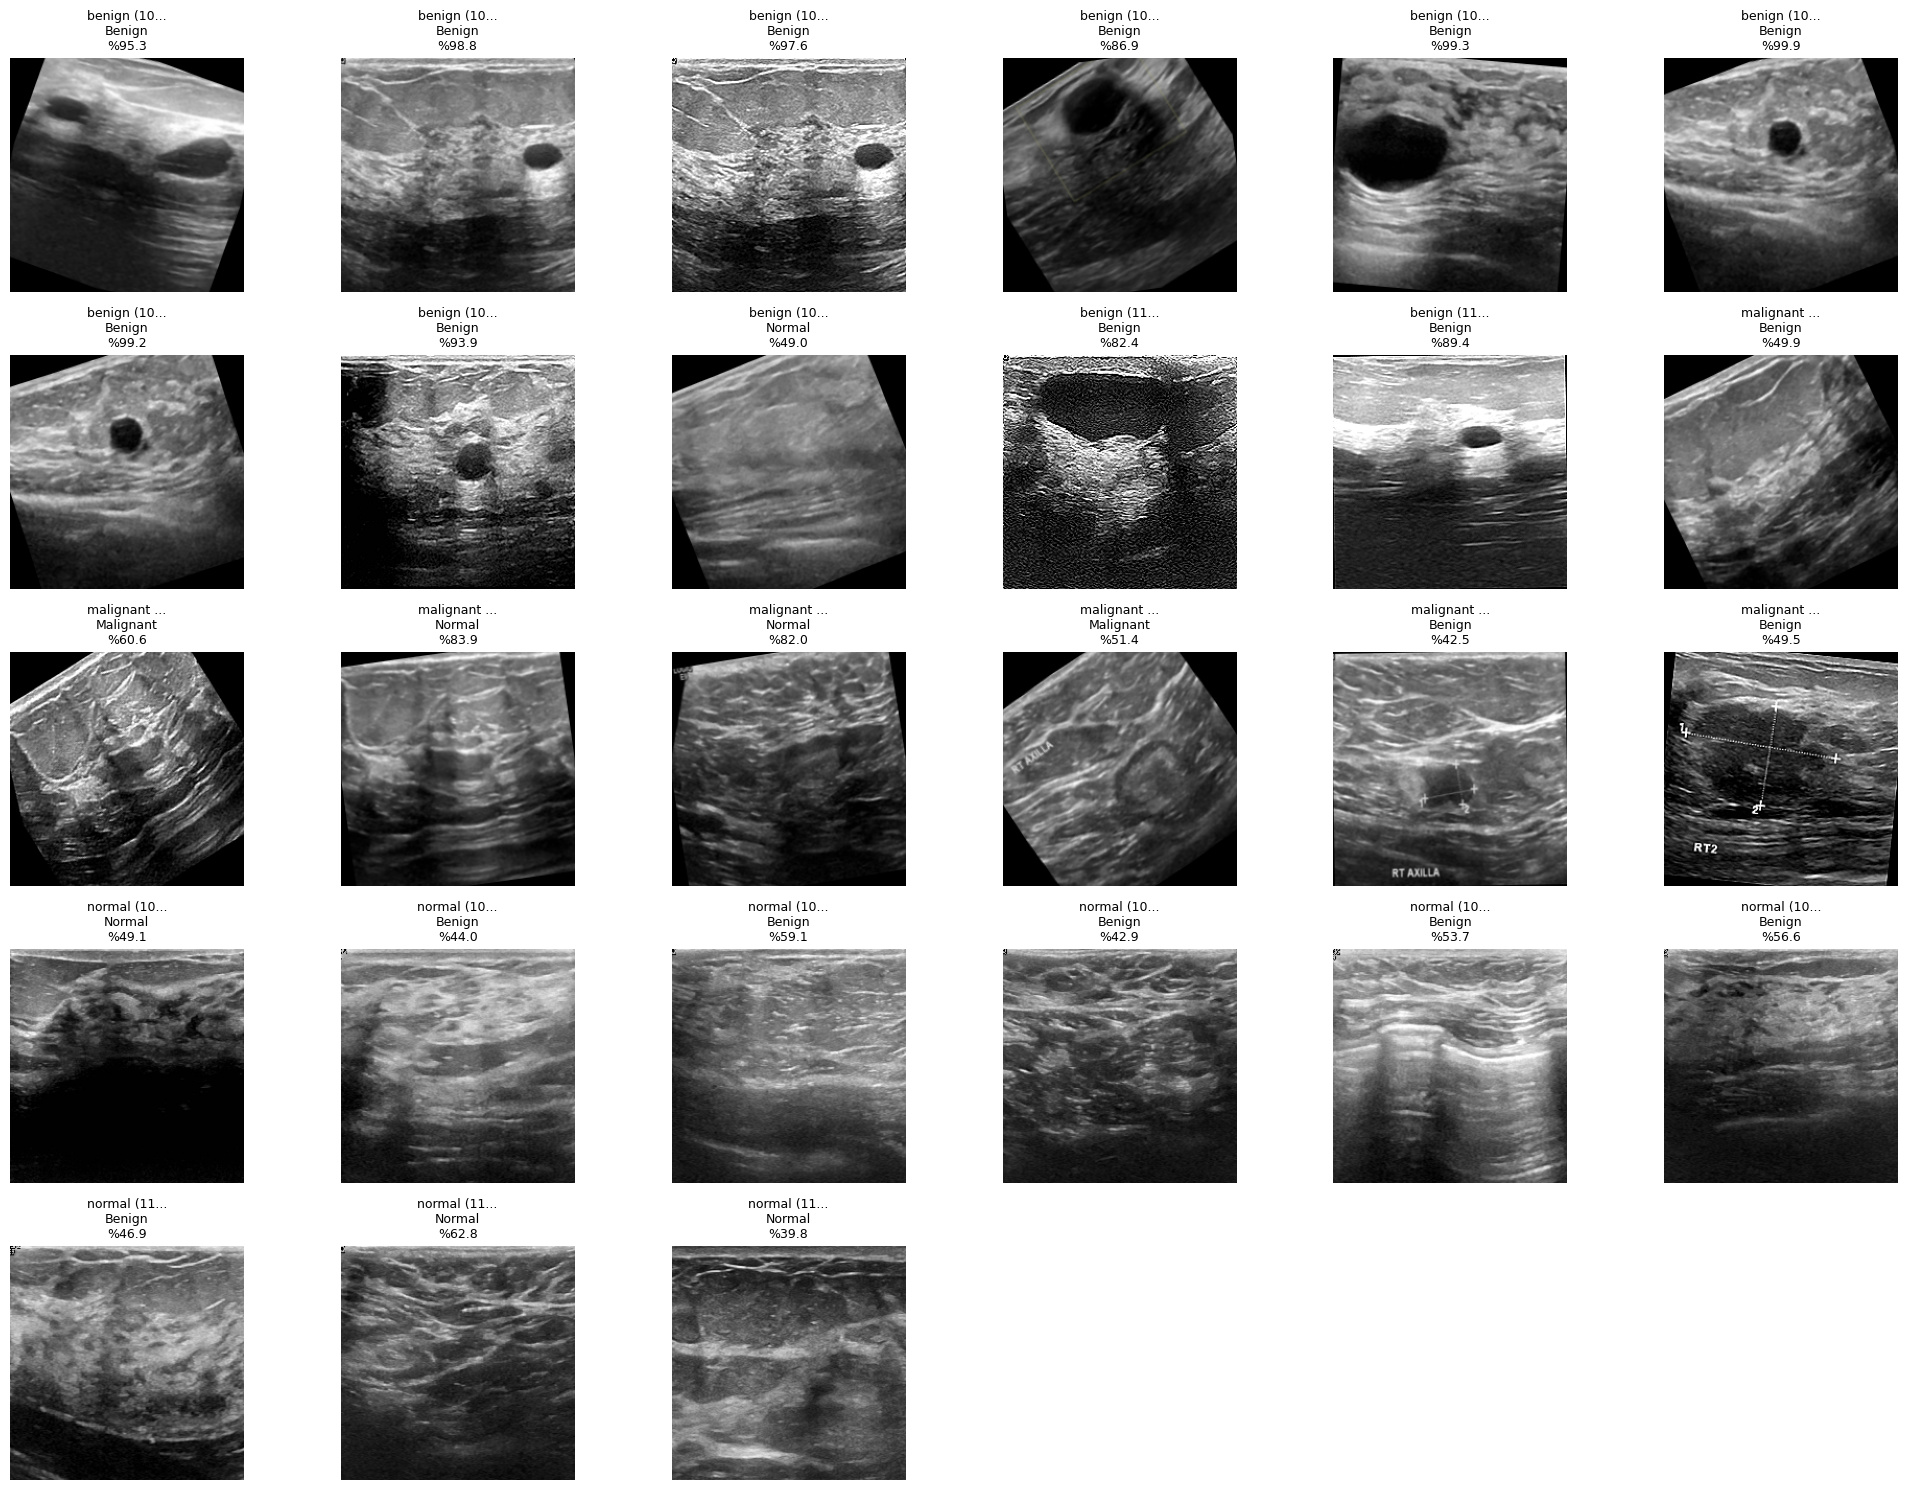

In [8]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input

# --- 1. ZIP DOSYASINI ÇIKARMA VE DOSYA YOLU KONTROLÜ ---
zip_path = '/content/denem.zip'
extract_path = '/content/denem_images'

# Yeniden temiz bir şekilde çıkarma işlemi
if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("✅ Zip dosyası başarıyla çıkarıldı.")

# Tüm alt klasörleri dolaşarak resimleri bul (Önemli Değişiklik)
image_files = []
for root, dirs, files in os.walk(extract_path):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_files.append(os.path.join(root, file))

image_files.sort()

if len(image_files) == 0:
    print("❌ HATA: Klasörde hiç resim bulunamadı! Lütfen zip içeriğini kontrol edin.")
else:
    print(f"🚀 {len(image_files)} adet resim bulundu, test başlıyor...\n")

    # --- 2. MODELİ YÜKLE ---
    MODEL_PATH = '/content/best_densenet_DA_30.keras'
    print(f"🔄 Model yükleniyor: {MODEL_PATH}")
    model = load_model(MODEL_PATH)

    # --- 3. SINIF İSİMLERİ ---
    # Not: Sınıf isimlerinin eğitimdeki alfabetik sırayla aynı olduğundan emin olun
    class_labels = ['Benign', 'Malignant', 'Normal']

    # --- 4. TAHMİN VE GÖRSELLEŞTİRME ---
    plt.figure(figsize=(20, 15))

    for i, img_path in enumerate(image_files):
        # Resmi yükle
        img = image.load_img(img_path, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x) # DenseNet preprocessing

        # Tahmin yap
        preds = model.predict(x, verbose=0)
        pred_class = np.argmax(preds, axis=1)[0]
        confidence = preds[0][pred_class] * 100

        # Dosya adını al
        img_name = os.path.basename(img_path)

        # Tabloya ekle (Max 30 resim için ayarlandı)
        if i < 30:
            plt.subplot(5, 6, i + 1)
            plt.imshow(img)
            plt.title(f"{img_name[:10]}...\n{class_labels[pred_class]}\n%{confidence:.1f}", fontsize=9)
            plt.axis('off')

        print(f"[{i+1}] {img_name} -> TAHMİN: {class_labels[pred_class]} (%{confidence:.2f})")

    plt.tight_layout()
    plt.show()

In [13]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils import class_weight

# --- 1. YOLLAR VE AYARLAR ---
BASE_PATH = '/content/otuz'
TRAIN_DIR = os.path.join(BASE_PATH, 'train')
TEST_DIR = os.path.join(BASE_PATH, 'test')
MODEL_PATH = '/content/drive/MyDrive/Ara Proje/saved_models/DenseNet_Results/DenseNet121_best_lr_1en03.keras'

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

# --- 2. VERİ YÜKLEYİCİLER (AUGMENTATION EKLENDİ) ---
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)

train_gen = train_datagen.flow_from_directory(TRAIN_DIR, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')
val_gen = test_val_datagen.flow_from_directory(TEST_DIR, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', subset='validation', shuffle=False)

# --- [B] SINIF AĞIRLIKLARINI HESAPLA ---
# Modelin az olan sınıflara (Malignant/Normal) daha çok önem vermesini sağlar
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)
class_weights_dict = dict(enumerate(weights))
print(f"📊 Sınıf Ağırlıkları Uygulanıyor: {class_weights_dict}")

# --- 3. MODELİ YÜKLE VE [C] KADEMELİ FINE-TUNING ---
print(f"🔄 Model yükleniyor...")
model = load_model(MODEL_PATH)

# --- AŞAMA 1: Sadece Üst Katmanları Eğit (Transfer Learning Koruma) ---
print("🛡️ Aşama 1: Temel katmanlar donduruluyor, sadece başlık eğitiliyor...")
for layer in model.layers[:-10]: # Son 10 katman hariç her yeri dondur
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_gen, epochs=5, validation_data=val_gen, class_weight=class_weights_dict)

# --- AŞAMA 2: Tüm Katmanları Aç ve İnce Ayar Yap ---
print("🔓 Aşama 2: Tüm katmanlar açılıyor (Fine-Tuning)...")
model.trainable = True

# [D] DINAMIK ÖĞRENME HIZI (ReduceLROnPlateau)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7, verbose=1)
checkpoint = ModelCheckpoint('/content/best_densenet_DA_v2.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.compile(optimizer=Adam(learning_rate=1e-5), # Çok düşük LR ile hassas eğitim
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# --- 5. ANA EĞİTİM ---
model.fit(
    train_gen,
    epochs=50,
    validation_data=val_gen,
    class_weight=class_weights_dict, # Sınıf ağırlıkları burada aktif
    callbacks=[checkpoint, early_stop, reduce_lr]
)

# --- 6. KAYDET ---
save_path = "/content/drive/MyDrive/Ara Proje/saved_models/DenseNet_Results/DA_Results/densenet_DA_v2_final.keras"
model.save(save_path)
print(f"✅ İyileştirilmiş model kaydedildi: {save_path}")

Found 648 images belonging to 3 classes.
Found 302 images belonging to 3 classes.
📊 Sınıf Ağırlıkları Uygulanıyor: {0: np.float64(0.9773755656108597), 1: np.float64(1.6240601503759398), 2: np.float64(0.7346938775510204)}
🔄 Model yükleniyor...
🛡️ Aşama 1: Temel katmanlar donduruluyor, sadece başlık eğitiliyor...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 74s 3s/step - accuracy: 0.4416 - loss: 1.3283 - val_accuracy: 0.5298 - val_loss: 1.0328
Epoch 2/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.4770 - loss: 1.3172 - val_accuracy: 0.4934 - val_loss: 1.0337
Epoch 3/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.4852 - loss: 1.1729 - val_accuracy: 0.5397 - val_loss: 0.9755
Epoch 4/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.5089 - loss: 1.1441 - val_accuracy: 0.6060 - val_loss: 0.8638
Epoch 5/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.5796 - loss: 0.9992 - val_accuracy: 0.6258 - val_loss: 0.8433
🔓 Aşama 2: Tüm katmanlar açılıyor (Fine-Tuning)...
Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5163 - loss: 1.0578   
Epoch 1: val_accuracy improved from -inf to 0.62252, saving model to /content/best_densenet_DA_v2.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step - accuracy: 0.5174 - loss: 1.0562 - val_accuracy: 0.6225 - val_loss: 0.8468 - learning_rate: 1.

🔄 İyileştirilmiş v2 Modeli Yükleniyor...
🚀 27 resim üzerinde v2 testi başlıyor...



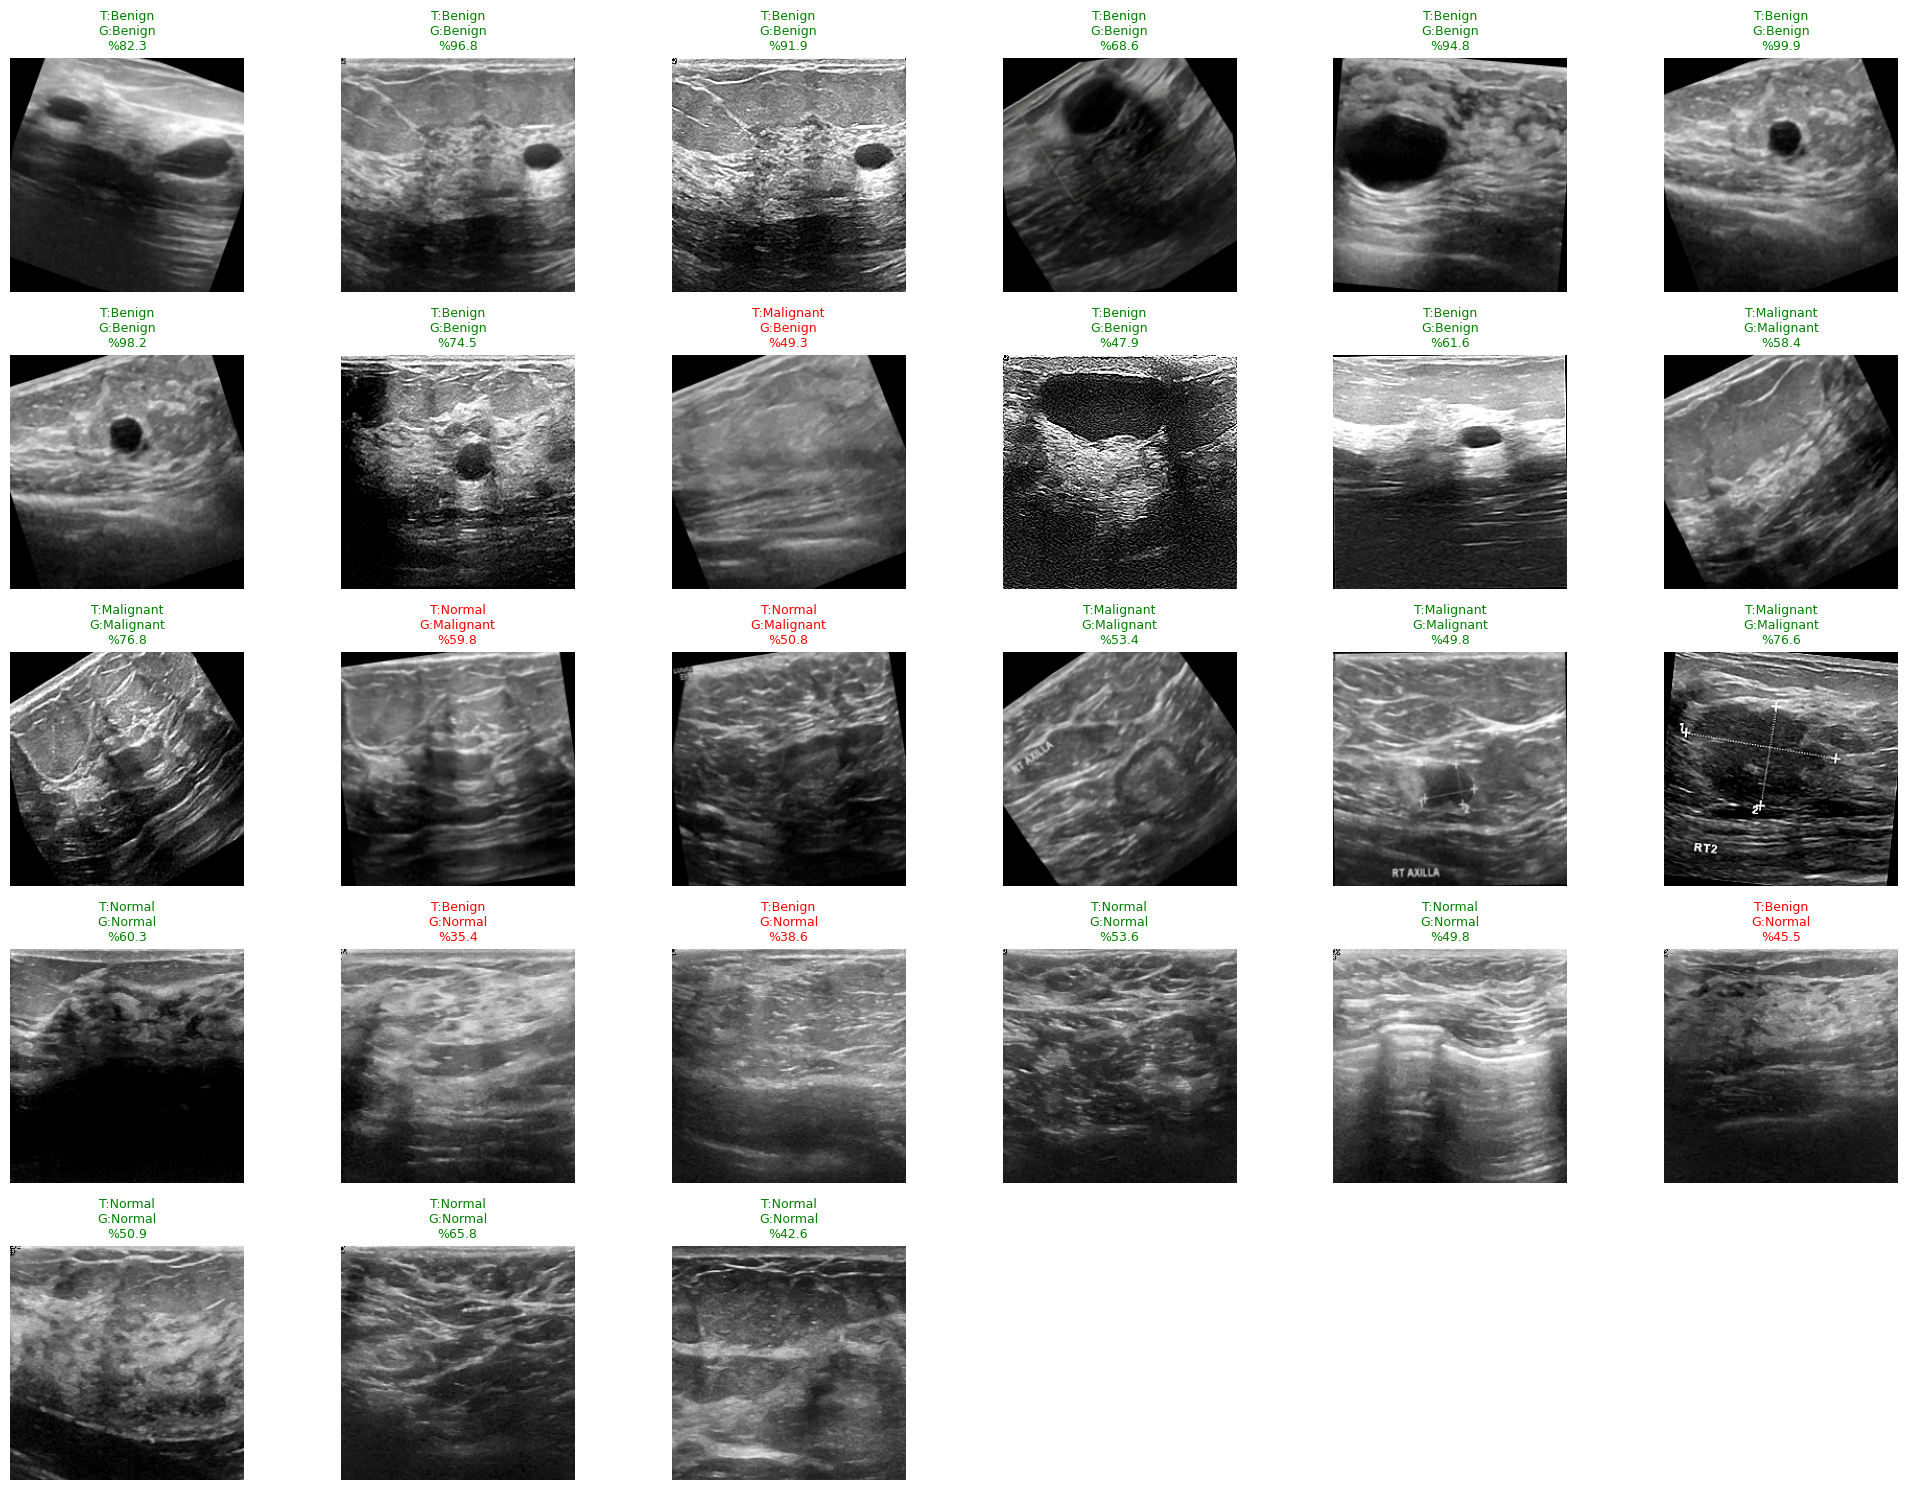


📊 YENİ MODEL SONUCU: 27 Resimden 21 Doğru!
✅ Yeni Başarı Oranı: %77.78


In [14]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input

# --- 1. MODELİ YÜKLE (Yeni v2 Modeli) ---
MODEL_PATH = '/content/best_densenet_DA_v2.keras'
print(f"🔄 İyileştirilmiş v2 Modeli Yükleniyor...")
model = load_model(MODEL_PATH)

# --- 2. ZIP VE RESİM HAZIRLIĞI ---
extract_path = '/content/denem_images'
image_files = []
for root, dirs, files in os.walk(extract_path):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_files.append(os.path.join(root, file))
image_files.sort()

class_labels = ['Benign', 'Malignant', 'Normal']

# --- 3. TEST VE ANALİZ ---
print(f"🚀 {len(image_files)} resim üzerinde v2 testi başlıyor...\n")

correct_count = 0
plt.figure(figsize=(20, 15))

for i, img_path in enumerate(image_files):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    preds = model.predict(x, verbose=0)
    pred_class = np.argmax(preds, axis=1)[0]
    confidence = preds[0][pred_class] * 100

    img_name = os.path.basename(img_path).lower()

    # Basit bir doğru/yanlış kontrolü (dosya isminden)
    actual_label = ""
    if "benign" in img_name: actual_label = "Benign"
    elif "malignant" in img_name: actual_label = "Malignant"
    elif "normal" in img_name: actual_label = "Normal"

    is_correct = (class_labels[pred_class] == actual_label)
    if is_correct: correct_count += 1

    # Görselleştirme
    plt.subplot(5, 6, i + 1)
    plt.imshow(img)
    color = 'green' if is_correct else 'red'
    plt.title(f"T:{class_labels[pred_class]}\nG:{actual_label}\n%{confidence:.1f}", color=color, fontsize=9)
    plt.axis('off')

plt.tight_layout()
plt.show()

print(f"\n📊 YENİ MODEL SONUCU: 27 Resimden {correct_count} Doğru!")
print(f"✅ Yeni Başarı Oranı: %{(correct_count/27)*100:.2f}")

In [22]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils import class_weight

# --- 1. YOLLAR VE AYARLAR ---
BASE_PATH = '/content/otuz'
TRAIN_DIR = os.path.join(BASE_PATH, 'train')
TEST_DIR = os.path.join(BASE_PATH, 'test')
MODEL_PATH = '/content/drive/MyDrive/Ara Proje/saved_models/DenseNet_Results/DenseNet121_best_lr_1en03.keras'

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

# --- 2. VERİ YÜKLEYİCİLER (TAMAMEN ORİJİNAL) ---
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)

train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, class_mode='categorical'
)

val_gen = test_val_datagen.flow_from_directory(
    TEST_DIR, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', subset='validation', shuffle=False
)

# --- 3. SINIF AĞIRLIKLARI ---
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)
class_weights_dict = dict(enumerate(weights))
print(f"📊 Sınıf Ağırlıkları Uygulanıyor: {class_weights_dict}")

# --- 4. MODELİ YÜKLE VE KATMANLARI AYARLA ---
print(f"🔄 Model yükleniyor...")
model = load_model(MODEL_PATH)

# Son 20 katman hariç her yeri donduruyoruz (İstediğin gibi direkt ayar)
model.trainable = True
for layer in model.layers[:-50]:
    layer.trainable = False

print("🛡️ Son 20 katman eğitime açıldı, diğerleri donduruldu.")

# --- 5. DERLEME VE EĞİTİM (DİREKT 50 EPOCH) ---
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callback'ler (Öğrenme hızı takılırsa ReduceLR devreye girer)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7, verbose=1)
checkpoint = ModelCheckpoint('/content/best_densenet_DA_v2_direct.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

print("\n🚀 Direkt 50 Epoch Eğitim Başlıyor...")
model.fit(
    train_gen,
    epochs=50,
    validation_data=val_gen,
    class_weight=class_weights_dict,
    callbacks=[checkpoint, early_stop, reduce_lr]
)

# --- 6. KAYDET ---
save_path = "/content/drive/MyDrive/Ara Proje/saved_models/DenseNet_Results/DA_Results/densenet_DA_v2_direct_final.keras"
if not os.path.exists(os.path.dirname(save_path)): os.makedirs(os.path.dirname(save_path))
model.save(save_path)
print(f"✅ İşlem tamamlandı. Kademesiz, direkt 50 epoch eğitim bitti.")

Found 648 images belonging to 3 classes.
Found 302 images belonging to 3 classes.
📊 Sınıf Ağırlıkları Uygulanıyor: {0: np.float64(0.9773755656108597), 1: np.float64(1.6240601503759398), 2: np.float64(0.7346938775510204)}
🔄 Model yükleniyor...
🛡️ Son 20 katman eğitime açıldı, diğerleri donduruldu.

🚀 Direkt 50 Epoch Eğitim Başlıyor...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 970ms/step - accuracy: 0.4627 - loss: 1.4033
Epoch 1: val_accuracy improved from -inf to 0.58609, saving model to /content/best_densenet_DA_v2_direct.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.4626 - loss: 1.4028 - val_accuracy: 0.5861 - val_loss: 0.9495 - learning_rate: 0.0010
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - accuracy: 0.4310 - loss: 1.4031
Epoch 2: val_accuracy did not improve from 0.58609
21/21 ━━━━━━━━━━━━━━━━━━━━ 16s 791ms/step - accuracy: 0.4329 - loss: 1.3957 - val_accuracy: 0.5861 - val_loss: 0.8962 - learning_rate: 0.0010
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - accuracy: 0.5040 - loss: 1.2036
Epoch 3: val_accuracy improved from 0.58609 to 0.63907, saving model to /content/best_densenet_DA_v2_direct.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 17s 837ms/step - accuracy: 0.5037 - loss: 1.2012 - val_accuracy: 0.6391 - val_loss: 0.8666 - learning_rate: 0.0010
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 52

🔄 Test Analizi Başlıyor. Model: /content/best_densenet_DA_v2_direct.keras
Found 1214 images belonging to 3 classes.

🔍 1214 test resmi üzerinde analiz yapılıyor...
38/38 ━━━━━━━━━━━━━━━━━━━━ 43s 830ms/step

🔥 FİNAL TEST SONUÇLARI (4 METRİK):
-----------------------------------------------------------------
              precision    recall  f1-score   support

      benign     0.7124    0.6416    0.6752       413
      malign     0.6029    0.6586    0.6296       249
      normal     0.7526    0.7772    0.7647       552

    accuracy                         0.7068      1214
   macro avg     0.6893    0.6925    0.6898      1214
weighted avg     0.7082    0.7068    0.7065      1214



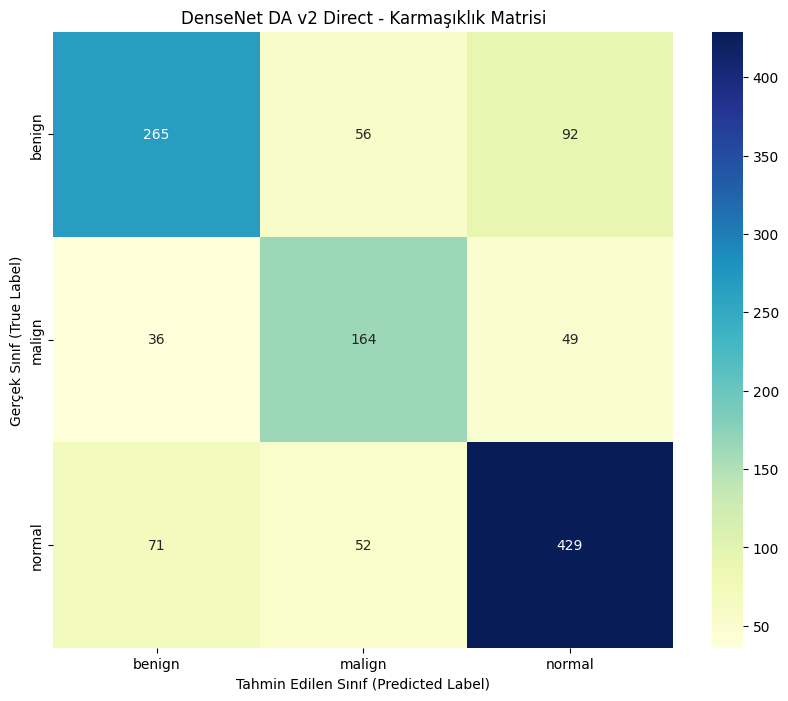


✅ GENEL TEST DOĞRULUK ORANI (ACCURACY): %70.68
-----------------------------------------------------------------


In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix

# --- 1. EN İYİ MODELİ YÜKLE ---
# Eğitimde kaydettiğin en iyi ağırlıklara sahip modeli yüklüyoruz
MODEL_PATH = '/content/best_densenet_DA_v2_direct.keras'
print(f"🔄 Test Analizi Başlıyor. Model: {MODEL_PATH}")

if not os.path.exists(MODEL_PATH):
    print("❌ HATA: Model dosyası bulunamadı! Lütfen yolu kontrol edin.")
else:
    model = load_model(MODEL_PATH)

    # --- 2. ANA TEST VERİSİ HAZIRLIĞI ---
    # Eğitimdeki veri bölme yapısına (validation_split=0.2) sadık kalarak %80'lik pure test kısmını alıyoruz
    TEST_DIR = '/content/otuz/test'
    test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)

    pure_test_gen = test_val_datagen.flow_from_directory(
        TEST_DIR,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        subset='training', # Eğitim kodundaki %80'lik dilim
        shuffle=False
    )

    # --- 3. TAHMİN VE HESAPLAMA ---
    print(f"\n🔍 {pure_test_gen.samples} test resmi üzerinde analiz yapılıyor...")
    Y_pred = model.predict(pure_test_gen)
    y_pred = np.argmax(Y_pred, axis=1)
    y_true = pure_test_gen.classes
    class_labels = list(pure_test_gen.class_indices.keys())

    # --- 4. 4 ANA METRİK VE SINIFLANDIRMA RAPORU ---
    print("\n🔥 FİNAL TEST SONUÇLARI (4 METRİK):")
    print("-" * 65)
    # Precision, Recall, F1-Score ve Support (Accuracy dahil) tabloyu yazdırır
    report = classification_report(y_true, y_pred, target_names=class_labels, digits=4)
    print(report)

    # --- 5. KARMAŞIKLIK MATRİSİ (CONFUSION MATRIX) ---
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
                xticklabels=class_labels, yticklabels=class_labels)

    plt.title('DenseNet DA v2 Direct - Karmaşıklık Matrisi')
    plt.ylabel('Gerçek Sınıf (True Label)')
    plt.xlabel('Tahmin Edilen Sınıf (Predicted Label)')
    plt.show()

    # --- 6. ÖZET DOĞRULUK ---
    final_acc = np.sum(y_true == y_pred) / len(y_true)
    print(f"\n✅ GENEL TEST DOĞRULUK ORANI (ACCURACY): %{final_acc*100:.2f}")
    print("-" * 65)